In [353]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
pd.set_option('display.max_columns', False)
import warnings
warnings.filterwarnings('ignore')

In [354]:
## Reading the data
lead_df=pd.read_csv("Leads.csv")
lead_df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [355]:
## Understanding the Data
lead_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

- Looks like there are quite a few categorical variables present in this dataset for which we will need to create dummy variables. Also, there are a lot of null values present as well, so we will need to treat them accordingly.

In [356]:
lead_df.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [357]:
lead_df.shape

(9240, 37)

## Data Cleaning

In [358]:
# replacing select values with non values
lead_df = lead_df.replace('Select', np.nan)

In [359]:
# checking the missing values
round(100*(lead_df.isnull().sum()/len(lead_df)),2).sort_values(ascending = False)

How did you hear about X Education               78.46
Lead Profile                                     74.19
Lead Quality                                     51.59
Asymmetrique Profile Score                       45.65
Asymmetrique Activity Score                      45.65
Asymmetrique Activity Index                      45.65
Asymmetrique Profile Index                       45.65
City                                             39.71
Specialization                                   36.58
Tags                                             36.29
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
Page Views Per Visit                              1.48
TotalVisits                                       1.48
Last Activity                                     1.11
Lead Source                                       0.39
Receive More Updates About Our Courses            0.00
I agree to

- we can find some columns with more than 40% of missing values

In [360]:
# Checking for the duplicates values
lead_df.loc[lead_df.duplicated()]

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity


- We can see no duplicate values

In [361]:
# Droping the columns of missing values
cols=lead_df.columns[round((lead_df.isnull().sum()/len(lead_df))*100)>=40]
lead_df=lead_df.drop(cols,1)

In [362]:
# droping the tags because this features is added by the sales team
lead_df.drop('Tags', 1, inplace=True)

In [363]:
lead_df.Country.value_counts()

India                   6492
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Canada                     4
Nigeria                    4
Germany                    4
Sweden                     3
Philippines                2
Italy                      2
Uganda                     2
Belgium                    2
Bangladesh                 2
Netherlands                2
China                      2
Ghana                      2
Asia/Pacific Region        2
Indonesia                  1
Denmark                    1
Vietnam                    1
Switzerland                1
Sri Lanka                  1
Malaysia                   1
Kenya         

In [364]:
# check the percentage of India as value in the country column

country_percentage = round(100*len(lead_df[lead_df['Country'] == 'India'])/len(lead_df['Country']),2)
print(country_percentage)

70.26


In [365]:
# finding the labels contain in the specialization variable
lead_df['Specialization'].value_counts()

Finance Management                   976
Human Resource Management            848
Marketing Management                 838
Operations Management                503
Business Administration              403
IT Projects Management               366
Supply Chain Management              349
Banking, Investment And Insurance    338
Media and Advertising                203
Travel and Tourism                   203
International Business               178
Healthcare Management                159
Hospitality Management               114
E-COMMERCE                           112
Retail Management                    100
Rural and Agribusiness                73
E-Business                            57
Services Excellence                   40
Name: Specialization, dtype: int64

In [366]:
# Imputing finance mangement as it common occurance in Specialization
lead_df['Specialization']=lead_df['Specialization'].replace(np.nan, "Finance Management")

In [367]:
# Finding the labels contains in the "What is your currnet occupation variable"
lead_df['What is your current occupation'].value_counts()

Unemployed              5600
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

In [368]:
# Imputing "unemployed" as its common occurance in waht is your current occupation Column
lead_df['What is your current occupation']=lead_df['What is your current occupation'].replace(np.nan, 'Unemployed')

In [369]:
# Finding the labels contains in the "what matters most to you in choosing a course" variable
lead_df['What matters most to you in choosing a course'].value_counts()

Better Career Prospects      6528
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

In [370]:
# dropping "What matters most to you in choosing a course" as we have almost same value for colums
lead_df.drop('What matters most to you in choosing a course',1, inplace=True)

In [371]:
# finding the labels contains in the last activity variable
lead_df['Last Activity'].value_counts()

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64

In [372]:
# Imputing Email opened as its common occurance i the last activity columns
lead_df['Last Activity']=lead_df['Last Activity'].fillna('Email Opened')

In [373]:
# Finding the lables contain in the "last Activity" variable
lead_df['Lead Source'].value_counts()

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Social Media            2
Press_Release           2
Live Chat               2
testone                 1
youtubechannel          1
blog                    1
Pay per Click Ads       1
NC_EDM                  1
WeLearn                 1
welearnblog_Home        1
Name: Lead Source, dtype: int64

In [374]:
# Imputing google as it common occurance in lead source colums
lead_df['Lead Source']=lead_df['Lead Source'].replace(np.nan, 'Google')

In [375]:
# google and Google is same just a typo
lead_df['Lead Source']= lead_df['Lead Source'].replace('google', 'Google')

In [376]:
lead_df['Total Time Spent on Website'].describe()

count    9240.000000
mean      487.698268
std       548.021466
min         0.000000
25%        12.000000
50%       248.000000
75%       936.000000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

### Outlier Detection

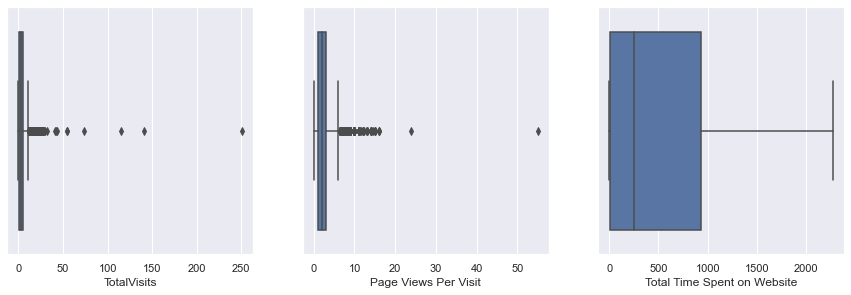

In [377]:
# Finding the Outliers
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.boxplot(lead_df['TotalVisits'])
plt.subplot(2,3,2)
sns.boxplot(lead_df['Page Views Per Visit'])
plt.subplot(2,3,3)
sns.boxplot(lead_df['Total Time Spent on Website'])
plt.xlabel('Total Time Spent on Website')
plt.show()

- Both TotalVisit and Page view per visit contain the outliers and it should be treated and the value spreaded above median highly in Total time spent on website

### Imputing Median to the missing values

In [378]:
#Imputing median as it is a continueous type
lead_df['TotalVisits']=lead_df['TotalVisits'].fillna(lead_df['TotalVisits'].median())
lead_df['Page Views Per Visit']=lead_df['Page Views Per Visit'].fillna(lead_df['Page Views Per Visit'].median())

In [379]:
lead_df[pd.isnull(lead_df).any(axis=1)==True]

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,What is your current occupation,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Finance Management,Unemployed,No,No,No,No,No,No,No,No,No,No,No,No,Modified
5,2058ef08-2858-443e-a01f-a9237db2f5ce,660680,API,Olark Chat,No,No,0,0.0,0,0.0,Olark Chat Conversation,NaN,Finance Management,Unemployed,No,No,No,No,No,No,No,No,No,No,No,No,Modified
7,20ef72a2-fb3b-45e0-924e-551c5fa59095,660664,API,Olark Chat,No,No,0,0.0,0,0.0,Olark Chat Conversation,NaN,Finance Management,Unemployed,No,No,No,No,No,No,No,No,No,No,No,No,Modified
16,3abb7c77-1634-4083-9a9f-861068220611,660540,API,Olark Chat,No,No,0,0.0,0,0.0,Olark Chat Conversation,NaN,Finance Management,Unemployed,No,No,No,No,No,No,No,No,No,No,No,No,Modified
47,3f04fd93-2884-45f6-a4fc-f3b6f234554b,660153,API,Olark Chat,No,No,0,0.0,0,0.0,Olark Chat Conversation,NaN,Finance Management,Unemployed,No,No,No,No,No,No,No,No,No,No,No,No,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9187,4f465f71-1946-414e-9716-4847c60606e8,579979,API,Olark Chat,No,No,1,0.0,0,0.0,SMS Sent,NaN,Finance Management,Unemployed,No,No,No,No,No,No,No,No,No,No,No,No,SMS Sent
9193,04b36f06-8e3e-4c99-9112-f162a2d1efc6,579926,Landing Page Submission,Direct Traffic,No,No,0,3.0,50,3.0,SMS Sent,NaN,IT Projects Management,Unemployed,No,No,No,No,No,No,No,No,No,No,No,Yes,SMS Sent
9199,6eb89ae5-d1e0-4c19-8661-8f9545e0e408,579892,API,Olark Chat,No,No,0,0.0,0,0.0,Olark Chat Conversation,NaN,Finance Management,Unemployed,No,No,No,No,No,No,No,No,No,No,No,No,Modified
9217,b8872c12-7534-498d-8f4a-e79a19516db1,579786,API,Olark Chat,No,No,0,0.0,0,0.0,SMS Sent,NaN,Finance Management,Unemployed,No,No,No,No,No,No,No,No,No,No,No,No,SMS Sent


In [380]:
# marking the lead number as index
lead_df=lead_df.set_index('Lead Number')
lead_df.drop(['Prospect ID'],1,inplace=True)

In [381]:
# Storing column with dtype object and column with dtype number in two different list, so we can easily Perform analysis 
col_obj=list(lead_df.loc[:, lead_df.dtypes == np.object].columns)
col_num=list(lead_df.loc[:, lead_df.dtypes == np.int64].columns)
col_num+=(list(lead_df.loc[:, lead_df.dtypes == np.number].columns))
print('columns with object dtype \n {} \n \n columns with number dtype \n {}'.format(col_obj,col_num))

columns with object dtype 
 ['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Last Activity', 'Country', 'Specialization', 'What is your current occupation', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity'] 
 
 columns with number dtype 
 ['Converted', 'Total Time Spent on Website', 'TotalVisits', 'Page Views Per Visit']


In [383]:
# Taking care of highly skewed columns  and one value only
lead_df=lead_df.drop(['What is your current occupation','Do Not Call','Do Not Email','Country','Search',\
                      'X Education Forums','Newspaper','Newspaper Article','Through Recommendations','Digital Advertisement'],1)

In [384]:
# Droping those variables which contains two labels but one is very High and another is very less number of labels.
lead_df=lead_df.drop(['Magazine','Receive More Updates About Our Courses','Update me on Supply Chain Content',\
                      'Get updates on DM Content','I agree to pay the amount through cheque', ],1)
col_obj=lead_df.loc[:, lead_df.dtypes == np.object].columns

### Maintaining the labels which columns contains lots of labels

In [385]:
# changing categories which are occured less than 1000
col_dict_ls=dict(lead_df['Lead Source'].value_counts()<1000)

# labels which are occured less like Reference,Reffereal site we can impute to 'Other'
for i in col_dict_ls.keys():
    if col_dict_ls[i]==True:
        lead_df['Lead Source']=lead_df['Lead Source'].replace(i,'Other')

In [386]:
# Changing categories which are occured less than 300
col_dict_la=dict(lead_df['Last Activity'].value_counts()<300)
# labels which are occured less like Resubscribed to emails ,Visited Booth in Tradeshow...those are impute to 'Other'

for i in col_dict_la.keys():
    if col_dict_la[i]==True:
        lead_df['Last Activity']=lead_df['Last Activity'].replace(i,'Other')

In [387]:
# Changing categories which are occured less than 500
col_dict_lna=dict(lead_df['Last Notable Activity'].value_counts()<500)
# labels which are occured less like Reference,Reffereal site we can impute to 'Other'

for i in col_dict_lna.keys():
    if col_dict_lna[i]==True:
        lead_df['Last Notable Activity']=lead_df['Last Notable Activity'].replace(i,'Other')

In [388]:
# Changing categories which are occured less than 350
col_dict_spec=dict(lead_df['Specialization'].value_counts()<350)
# labels which are occured less like E-Business,Retail Management we can impute to 'Other'

for i in col_dict_spec.keys():
    if col_dict_spec[i]==True:
        lead_df['Specialization']=lead_df['Specialization'].replace(i,'Other')

### Exploratory Data Analysis

In [389]:
# crating cols which contains only Categorical variable
cols=lead_df.loc[:, lead_df.dtypes == np.object].columns
cols

Index(['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

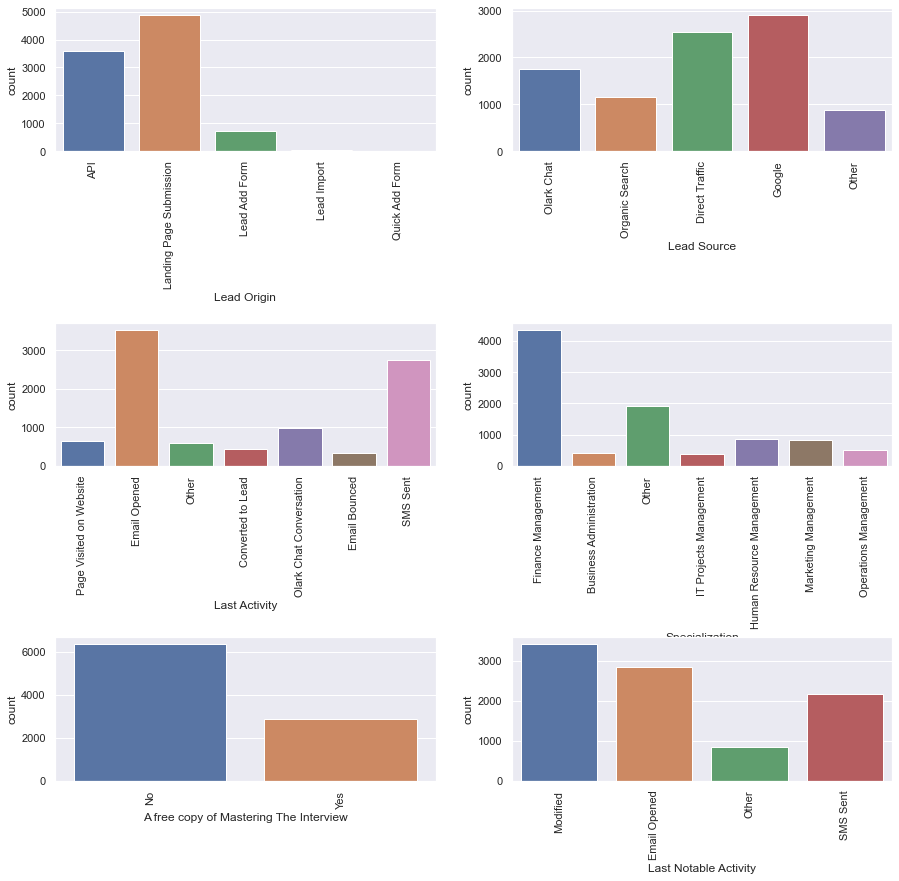

In [390]:
plt.figure(figsize=(15,20))
sns.set()
plt.subplots_adjust(wspace=.2,hspace=1.2 )
for i in enumerate(col_obj):
    plt.subplot(4,2, i[0]+1)
    sns.countplot(i[1],data=lead_df)
    plt.xticks(rotation=90)
plt.show()

### Insights :-
- In Lead Source Direct Traffic and Google are the two main source for Leads
- The Number of values is High in Email Opened and SMS Sent in Last Activity
- Most of the people chooses Finance Management Specialization rather than other Specialization
- The IT Project management have very lees so that most of the People not prefered this Specialization

## Univariate Analysis(Continuous Data)

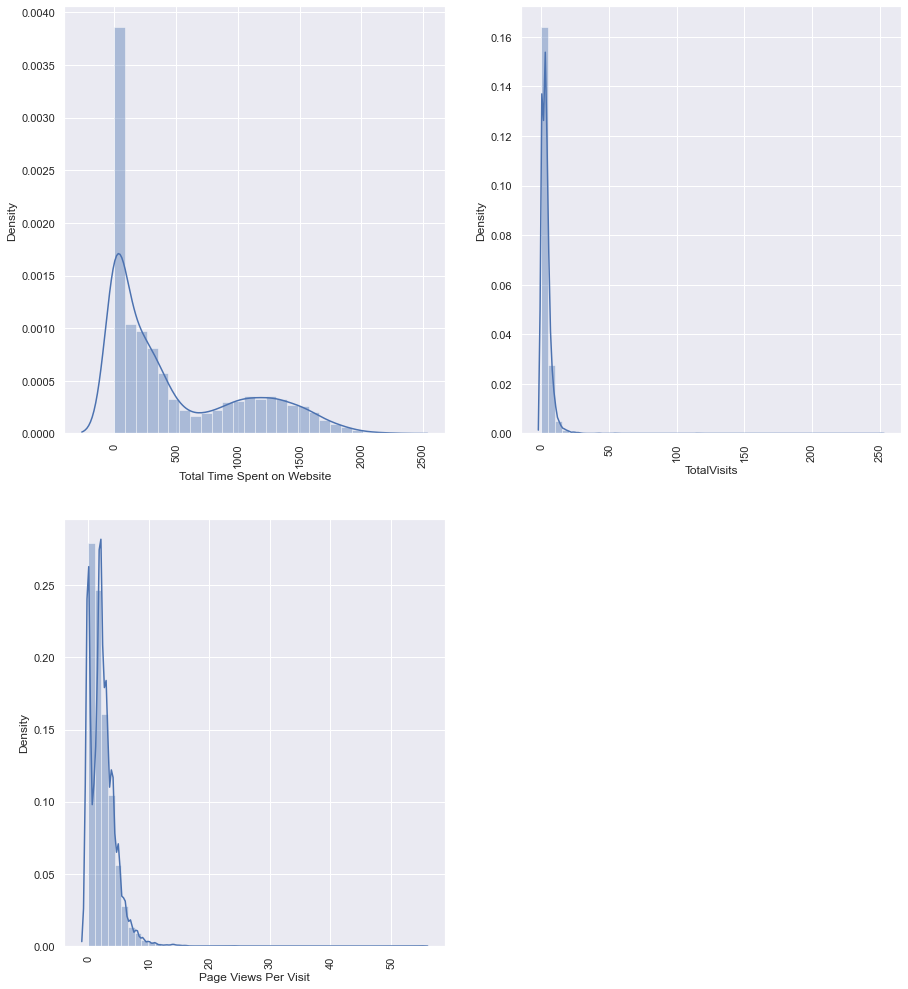

In [391]:
col_num.remove('Converted')

plt.figure(figsize=(15,15))
plt.subplots_adjust(bottom=.01)
for i in enumerate(col_num):
    
    plt.subplot(2,2, i[0]+1)
    sns.distplot(lead_df[i[1]])
    
    plt.xticks(rotation=90)
# plt.savefig('coniouus_univar.png',dpi=300,transparent=True)
plt.show()

## Insights :-
- None of the Continueous Variables are in Normal distribution
- Presence of Outliers in Total Visits and Page Views Per Visit
- In total visits more values is between 0-50 and page views per visits 0-20

## Bivariate Analysis
### Bivariate Analysis With respect to Target Column Converted

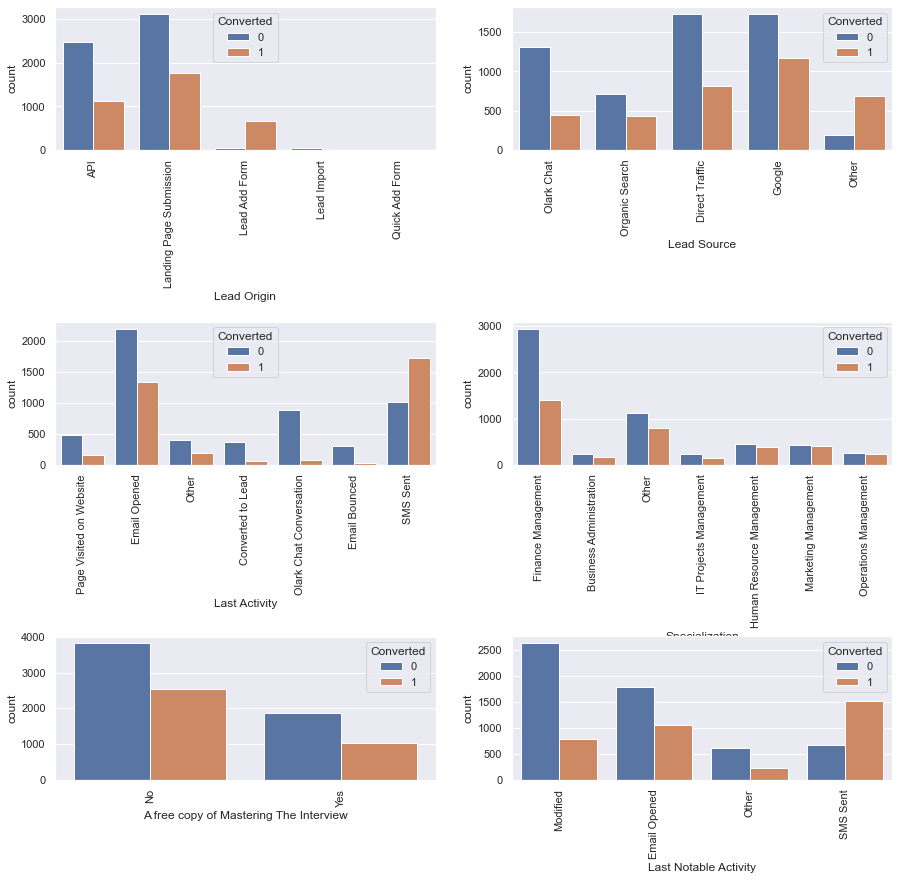

In [392]:
plt.figure(figsize=(15,20))
plt.subplots_adjust(wspace=.2,hspace=1.2 )
for i in enumerate(col_obj):
    plt.subplot(4,2, i[0]+1)
    sns.countplot(x = i[1],hue = 'Converted', data = lead_df)
    plt.xticks(rotation=90)
# plt.savefig('cate bivar.png',dpi=300,transparent=True)
plt.show()

### Insights :-
- In Lead Source The number of Hot leads is higher in Direct Traffic and Google less in Other Category
- In Last Activity the number of Hot leads is higher in SMS and in EMAIL cold leads is higher than hot leads.
- In Last Notable Activity it's mostly same as Last Activity.
- In Specialization the most of the leads are comes from Finance management but here Hot leads are lesseer than Cold leads.

## Data Preparation and Features Selection

In [393]:
lead_df.head()

,Lead Origin,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,A free copy of Mastering The Interview,Last Notable Activity
Lead Number,,,,,,,,,,
660737,API,Olark Chat,0,0.0,0,0.0,Page Visited on Website,Finance Management,No,Modified
660728,API,Organic Search,0,5.0,674,2.5,Email Opened,Finance Management,No,Email Opened
660727,Landing Page Submission,Direct Traffic,1,2.0,1532,2.0,Email Opened,Business Administration,Yes,Email Opened
660719,Landing Page Submission,Direct Traffic,0,1.0,305,1.0,Other,Other,No,Modified
660681,Landing Page Submission,Google,1,2.0,1428,1.0,Converted to Lead,Finance Management,No,Modified


### Column Mapping

In [394]:
# mapping of columns

lead_df['A free copy of Mastering The Interview']=lead_df['A free copy of Mastering The Interview'].apply(lambda x: 1 if x=='Yes' else 0)

In [395]:
# Dropping the Last Notable Activity as it is mostly same Last Activity
lead_df.drop('Last Notable Activity',1,inplace=True)

## Creating Dummy Variables for Categorical Variables

In [396]:
dummies_df=pd.get_dummies(lead_df)
dummies_df.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_API,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Specialization_Business Administration,Specialization_Finance Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_Marketing Management,Specialization_Operations Management,Specialization_Other
Lead Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
660737,0,0.0,0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
660728,0,5.0,674,2.5,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
660727,1,2.0,1532,2.0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
660719,0,1.0,305,1.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
660681,1,2.0,1428,1.0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [397]:
# dropping columns on basis of anal

dummies_df=dummies_df.drop(['A free copy of Mastering The Interview','Lead Origin_Lead Add Form','Lead Source_Organic Search','Last Activity_Email Opened','Specialization_Operations Management'],1)

## Splitting the Data into Training and Testing Sets

In [398]:
X=dummies_df.iloc[:,1:]
y=dummies_df[['Converted']]

In [399]:
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=.7,test_size=.3,random_state=1)

### Scaling the Features

In [400]:
scaler=StandardScaler()
X_train[['Total Time Spent on Website','Page Views Per Visit','TotalVisits']]=\
scaler.fit_transform(X_train[['Total Time Spent on Website','Page Views Per Visit','TotalVisits']])

### Correlation

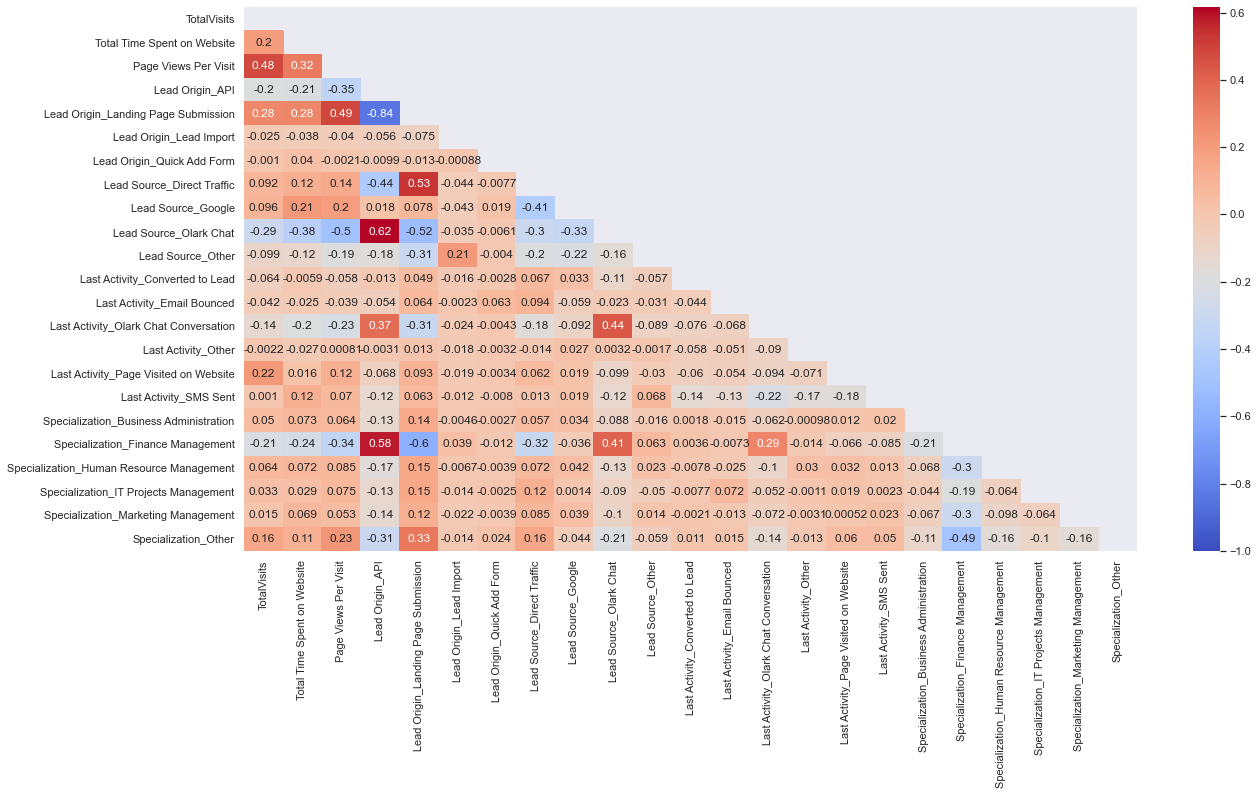

In [401]:
# Finding the Correlation using HeatMap
plt.figure(figsize = (20, 10))
mask = np.zeros(X_train.corr().shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(X_train.corr(), annot = True, vmin=-1,cmap='coolwarm',mask=mask)
plt.show()

### Interpretation
- We can see some columns are highly correlated
- we will let RFE to decide to drop columns or not

In [402]:
# Using rfe for features selection
logreg=LogisticRegression()

In [403]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=logreg, n_features_to_select=20)  # running RFE
rfe = rfe.fit(X_train, y_train)

In [404]:
rfe.support_

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True])

In [405]:
list(zip(X_train.columns, rfe.support_,rfe.ranking_))

[('TotalVisits', True, 1),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', True, 1),
 ('Lead Origin_API', True, 1),
 ('Lead Origin_Landing Page Submission', True, 1),
 ('Lead Origin_Lead Import', True, 1),
 ('Lead Origin_Quick Add Form', False, 3),
 ('Lead Source_Direct Traffic', True, 1),
 ('Lead Source_Google', True, 1),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Other', True, 1),
 ('Last Activity_Converted to Lead', True, 1),
 ('Last Activity_Email Bounced', True, 1),
 ('Last Activity_Olark Chat Conversation', True, 1),
 ('Last Activity_Other', True, 1),
 ('Last Activity_Page Visited on Website', True, 1),
 ('Last Activity_SMS Sent', True, 1),
 ('Specialization_Business Administration', True, 1),
 ('Specialization_Finance Management', True, 1),
 ('Specialization_Human Resource Management', True, 1),
 ('Specialization_IT Projects Management', False, 2),
 ('Specialization_Marketing Management', False, 4),
 ('Specialization_Other', True, 1)]

In [406]:
# after used rfe here rfe selected these variables should be used for modeling
col=X_train.columns[rfe.support_]
col

Index(['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
       'Lead Origin_API', 'Lead Origin_Landing Page Submission',
       'Lead Origin_Lead Import', 'Lead Source_Direct Traffic',
       'Lead Source_Google', 'Lead Source_Olark Chat', 'Lead Source_Other',
       'Last Activity_Converted to Lead', 'Last Activity_Email Bounced',
       'Last Activity_Olark Chat Conversation', 'Last Activity_Other',
       'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent',
       'Specialization_Business Administration',
       'Specialization_Finance Management',
       'Specialization_Human Resource Management', 'Specialization_Other'],
      dtype='object')

In [407]:
# after used rfe here refe selected variable should not be use here
X_train.columns[~rfe.support_]

Index(['Lead Origin_Quick Add Form', 'Specialization_IT Projects Management',
       'Specialization_Marketing Management'],
      dtype='object')

## Building a logistic regression using 
#### Model 1

In [408]:
X_train_sm=sm.add_constant(X_train[col])
logm1=sm.GLM(y_train, X_train_sm, families=sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6447
Model Family:                Gaussian   Df Model:                           20
Link Function:               identity   Scale:                         0.14833
Method:                          IRLS   Log-Likelihood:                -2995.6
Date:                Tue, 18 Jul 2023   Deviance:                       956.27
Time:                        18:55:38   Pearson chi2:                     956.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        0.9769      0.042     23.181      0.000       0.894       1.059
TotalVisits                                  0.0250      0.006      4.461      0.000       0.014       0.036
Total Time Spent on Website                  0.1983      0.005     36.658      0.000       0.188       0.209
Page Views Per Visit                        -0.0236      0.007     -3.460      0.001      -0.037      -0.010
Lead Origin_API                             -0.6015      0.039    -15.512      0.000      -0.677      -0.525
Lead Origin_Landing Page Submission         -0.6523      0.040    -16.274      0.000      -0.731      -0.574
Lead Origin_Lead Import                     -0.6247      0.070     -8.875      0.000      -0.763      -0.487
Lead Source_Direct Traffic                  -0.0420      0.018     -2.352      0.019      -0.077      -0.007
Lead Source_Google                           0.0173      0.017      1.043      0.297      -0.015       0.050
Lead Source_Olark Chat                       0.1535      0.023      6.634      0.000       0.108       0.199
Lead Source_Other                            0.0033      0.037      0.090      0.929      -0.069       0.076
Last Activity_Converted to Lead             -0.1447      0.024     -5.982      0.000      -0.192      -0.097
Last Activity_Email Bounced                 -0.2013      0.026     -7.689      0.000      -0.253      -0.150
Last Activity_Olark Chat Conversation       -0.2173      0.018    -11.825      0.000      -0.253      -0.181
Last Activity_Other                         -0.0449      0.021     -2.182      0.029      -0.085      -0.005
Last Activity_Page Visited on Website       -0.1114      0.020     -5.513      0.000      -0.151      -0.072
Last Activity_SMS Sent                       0.2082      0.012     17.593      0.000       0.185       0.231
Specialization_Business Administration      -0.0371      0.025     -1.465      0.143      -0.087       0.013
Specialization_Finance Management           -0.0912      0.015     -6.030      0.000      -0.121      -0.062
Specialization_Human Resource Management    -0.0192      0.020     -0.983      0.326      -0.058       0.019
Specialization_Other                        -0.0215      0.016     -1.381      0.167      -0.052       0.009
============================================================================================================
"""

In [409]:
# function to calculatevif
def vifcalc(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF']=[variance_inflation_factor(df.values, i)for i in range(df.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif = vif.sort_values(by="VIF", ascending = False)
    return vif

In [410]:
# calculate the vif for new model
vifcalc(X_train[col])

,Features,VIF
4,Lead Origin_Landing Page Submission,8.43
3,Lead Origin_API,7.07
17,Specialization_Finance Management,4.45
8,Lead Source_Olark Chat,4.42
6,Lead Source_Direct Traffic,3.65
7,Lead Source_Google,3.44
19,Specialization_Other,2.09
2,Page Views Per Visit,2.00
15,Last Activity_SMS Sent,1.73
9,Lead Source_Other,1.57


- Lead Source_Other is insignificant because it has high p-value in presence of other variables so it should be dropped

In [411]:
col=col.drop('Lead Source_Other',1)

#### Model 2

In [412]:
X_train_sm=sm.add_constant(X_train[col])
logm2=sm.GLM(y_train,X_train_sm, families=sm.families.Binomial()).fit()
logm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6448
Model Family:                Gaussian   Df Model:                           19
Link Function:               identity   Scale:                         0.14830
Method:                          IRLS   Log-Likelihood:                -2995.6
Date:                Tue, 18 Jul 2023   Deviance:                       956.27
Time:                        18:55:38   Pearson chi2:                     956.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        0.9801      0.022     44.230      0.000       0.937       1.024
TotalVisits                                  0.0250      0.006      4.465      0.000       0.014       0.036
Total Time Spent on Website                  0.1983      0.005     36.662      0.000       0.188       0.209
Page Views Per Visit                        -0.0236      0.007     -3.462      0.001      -0.037      -0.010
Lead Origin_API                             -0.6041      0.025    -24.087      0.000      -0.653      -0.555
Lead Origin_Landing Page Submission         -0.6550      0.026    -25.449      0.000      -0.705      -0.605
Lead Origin_Lead Import                     -0.6247      0.070     -8.875      0.000      -0.763      -0.487
Lead Source_Direct Traffic                  -0.0424      0.017     -2.463      0.014      -0.076      -0.009
Lead Source_Google                           0.0168      0.016      1.075      0.282      -0.014       0.048
Lead Source_Olark Chat                       0.1529      0.022      6.861      0.000       0.109       0.197
Last Activity_Converted to Lead             -0.1447      0.024     -5.987      0.000      -0.192      -0.097
Last Activity_Email Bounced                 -0.2013      0.026     -7.697      0.000      -0.253      -0.150
Last Activity_Olark Chat Conversation       -0.2173      0.018    -11.826      0.000      -0.253      -0.181
Last Activity_Other                         -0.0449      0.021     -2.181      0.029      -0.085      -0.005
Last Activity_Page Visited on Website       -0.1114      0.020     -5.513      0.000      -0.151      -0.072
Last Activity_SMS Sent                       0.2082      0.012     17.617      0.000       0.185       0.231
Specialization_Business Administration      -0.0371      0.025     -1.466      0.143      -0.087       0.013
Specialization_Finance Management           -0.0912      0.015     -6.031      0.000      -0.121      -0.062
Specialization_Human Resource Management    -0.0192      0.020     -0.983      0.326      -0.058       0.019
Specialization_Other                        -0.0215      0.016     -1.385      0.166      -0.052       0.009
============================================================================================================
"""

In [413]:
# calculate the VIF for the new model
vifcalc(X_train[col])

,Features,VIF
4,Lead Origin_Landing Page Submission,8.38
3,Lead Origin_API,6.92
8,Lead Source_Olark Chat,4.18
16,Specialization_Finance Management,3.72
6,Lead Source_Direct Traffic,3.56
7,Lead Source_Google,3.33
2,Page Views Per Visit,1.94
18,Specialization_Other,1.92
14,Last Activity_SMS Sent,1.65
11,Last Activity_Olark Chat Conversation,1.55


- Specialization_Human Resource Management is insignificant because it has high p-value in presence of other variables so it should be dropped

In [414]:
col=col.drop('Specialization_Human Resource Management',1)

#### Model 3

In [415]:
X_train_sm=sm.add_constant(X_train[col])
logm3=sm.GLM(y_train,X_train_sm, families=sm.families.Binomial()).fit()
logm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6449
Model Family:                Gaussian   Df Model:                           18
Link Function:               identity   Scale:                         0.14830
Method:                          IRLS   Log-Likelihood:                -2996.1
Date:                Tue, 18 Jul 2023   Deviance:                       956.41
Time:                        18:55:39   Pearson chi2:                     956.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.9731      0.021     46.340      0.000       0.932       1.014
TotalVisits                                0.0249      0.006      4.443      0.000       0.014       0.036
Total Time Spent on Website                0.1982      0.005     36.657      0.000       0.188       0.209
Page Views Per Visit                      -0.0236      0.007     -3.466      0.001      -0.037      -0.010
Lead Origin_API                           -0.6035      0.025    -24.069      0.000      -0.653      -0.554
Lead Origin_Landing Page Submission       -0.6544      0.026    -25.433      0.000      -0.705      -0.604
Lead Origin_Lead Import                   -0.6247      0.070     -8.876      0.000      -0.763      -0.487
Lead Source_Direct Traffic                -0.0421      0.017     -2.449      0.014      -0.076      -0.008
Lead Source_Google                         0.0168      0.016      1.074      0.283      -0.014       0.048
Lead Source_Olark Chat                     0.1528      0.022      6.855      0.000       0.109       0.196
Last Activity_Converted to Lead           -0.1448      0.024     -5.991      0.000      -0.192      -0.097
Last Activity_Email Bounced               -0.2007      0.026     -7.674      0.000      -0.252      -0.149
Last Activity_Olark Chat Conversation     -0.2170      0.018    -11.812      0.000      -0.253      -0.181
Last Activity_Other                       -0.0452      0.021     -2.196      0.028      -0.085      -0.005
Last Activity_Page Visited on Website     -0.1118      0.020     -5.535      0.000      -0.151      -0.072
Last Activity_SMS Sent                     0.2083      0.012     17.628      0.000       0.185       0.231
Specialization_Business Administration    -0.0308      0.024     -1.256      0.209      -0.079       0.017
Specialization_Finance Management         -0.0850      0.014     -6.195      0.000      -0.112      -0.058
Specialization_Other                      -0.0152      0.014     -1.074      0.283      -0.043       0.013
==========================================================================================================
"""

In [416]:
# calculate the Vifs forthe new model
vifcalc(X_train[col])

,Features,VIF
4,Lead Origin_Landing Page Submission,7.76
3,Lead Origin_API,6.62
8,Lead Source_Olark Chat,4.18
6,Lead Source_Direct Traffic,3.56
16,Specialization_Finance Management,3.33
7,Lead Source_Google,3.33
2,Page Views Per Visit,1.93
17,Specialization_Other,1.70
14,Last Activity_SMS Sent,1.64
11,Last Activity_Olark Chat Conversation,1.55


- Lead Source_Google is insignificant because it has high p-value in presence of other variables so it should be dropped

In [417]:
col=col.drop('Lead Source_Google',1)

#### Model 4

In [418]:
X_train_sm=sm.add_constant(X_train[col])
logm4=sm.GLM(y_train,X_train_sm, families=sm.families.Binomial()).fit()
logm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6450
Model Family:                Gaussian   Df Model:                           17
Link Function:               identity   Scale:                         0.14831
Method:                          IRLS   Log-Likelihood:                -2996.7
Date:                Tue, 18 Jul 2023   Deviance:                       956.58
Time:                        18:55:39   Pearson chi2:                     957.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.9734      0.021     46.352      0.000       0.932       1.015
TotalVisits                                0.0246      0.006      4.391      0.000       0.014       0.036
Total Time Spent on Website                0.1984      0.005     36.719      0.000       0.188       0.209
Page Views Per Visit                      -0.0249      0.007     -3.708      0.000      -0.038      -0.012
Lead Origin_API                           -0.5913      0.022    -26.426      0.000      -0.635      -0.547
Lead Origin_Landing Page Submission       -0.6413      0.023    -28.339      0.000      -0.686      -0.597
Lead Origin_Lead Import                   -0.6245      0.070     -8.873      0.000      -0.762      -0.487
Lead Source_Direct Traffic                -0.0543      0.013     -4.184      0.000      -0.080      -0.029
Lead Source_Olark Chat                     0.1396      0.019      7.509      0.000       0.103       0.176
Last Activity_Converted to Lead           -0.1462      0.024     -6.059      0.000      -0.194      -0.099
Last Activity_Email Bounced               -0.2020      0.026     -7.731      0.000      -0.253      -0.151
Last Activity_Olark Chat Conversation     -0.2168      0.018    -11.804      0.000      -0.253      -0.181
Last Activity_Other                       -0.0450      0.021     -2.189      0.029      -0.085      -0.005
Last Activity_Page Visited on Website     -0.1119      0.020     -5.542      0.000      -0.152      -0.072
Last Activity_SMS Sent                     0.2081      0.012     17.614      0.000       0.185       0.231
Specialization_Business Administration    -0.0309      0.024     -1.263      0.207      -0.079       0.017
Specialization_Finance Management         -0.0854      0.014     -6.230      0.000      -0.112      -0.059
Specialization_Other                      -0.0170      0.014     -1.208      0.227      -0.044       0.011
==========================================================================================================
"""

In [419]:
#calculate the VIF for new model
vifcalc(X_train[col])

,Features,VIF
3,Lead Origin_API,4.39
4,Lead Origin_Landing Page Submission,4.20
15,Specialization_Finance Management,3.32
7,Lead Source_Olark Chat,2.88
6,Lead Source_Direct Traffic,2.02
2,Page Views Per Visit,1.87
16,Specialization_Other,1.67
13,Last Activity_SMS Sent,1.64
10,Last Activity_Olark Chat Conversation,1.55
0,TotalVisits,1.36


- Specialization_Business Administration is insignificant because it has high p-value in presence of other variables so it should be dropped

In [420]:
col=col.drop('Specialization_Business Administration',1)

#### Model 5

In [421]:
X_train_sm=sm.add_constant(X_train[col])
logm5=sm.GLM(y_train,X_train_sm, families=sm.families.Binomial()).fit()
logm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6451
Model Family:                Gaussian   Df Model:                           16
Link Function:               identity   Scale:                         0.14832
Method:                          IRLS   Log-Likelihood:                -2997.5
Date:                Tue, 18 Jul 2023   Deviance:                       956.82
Time:                        18:55:40   Pearson chi2:                     957.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.9694      0.021     46.683      0.000       0.929       1.010
TotalVisits                               0.0245      0.006      4.370      0.000       0.013       0.035
Total Time Spent on Website               0.1983      0.005     36.700      0.000       0.188       0.209
Page Views Per Visit                     -0.0248      0.007     -3.695      0.000      -0.038      -0.012
Lead Origin_API                          -0.5912      0.022    -26.421      0.000      -0.635      -0.547
Lead Origin_Landing Page Submission      -0.6420      0.023    -28.377      0.000      -0.686      -0.598
Lead Origin_Lead Import                  -0.6252      0.070     -8.882      0.000      -0.763      -0.487
Lead Source_Direct Traffic               -0.0539      0.013     -4.155      0.000      -0.079      -0.028
Lead Source_Olark Chat                    0.1393      0.019      7.496      0.000       0.103       0.176
Last Activity_Converted to Lead          -0.1464      0.024     -6.067      0.000      -0.194      -0.099
Last Activity_Email Bounced              -0.2015      0.026     -7.714      0.000      -0.253      -0.150
Last Activity_Olark Chat Conversation    -0.2169      0.018    -11.805      0.000      -0.253      -0.181
Last Activity_Other                      -0.0448      0.021     -2.178      0.029      -0.085      -0.004
Last Activity_Page Visited on Website    -0.1120      0.020     -5.544      0.000      -0.152      -0.072
Last Activity_SMS Sent                    0.2081      0.012     17.611      0.000       0.185       0.231
Specialization_Finance Management        -0.0813      0.013     -6.104      0.000      -0.107      -0.055
Specialization_Other                     -0.0125      0.014     -0.923      0.356      -0.039       0.014
=========================================================================================================
"""

In [422]:
## calculate the VIF for the new model

In [423]:
vifcalc(X_train[col])

,Features,VIF
3,Lead Origin_API,4.30
4,Lead Origin_Landing Page Submission,3.95
14,Specialization_Finance Management,3.20
7,Lead Source_Olark Chat,2.88
6,Lead Source_Direct Traffic,2.02
2,Page Views Per Visit,1.86
13,Last Activity_SMS Sent,1.63
15,Specialization_Other,1.59
10,Last Activity_Olark Chat Conversation,1.55
0,TotalVisits,1.36


- Specialization_Other is insignificant because it has high p-value in presence of other variables so it should be dropped

In [424]:
col=col.drop('Specialization_Other',1)

#### Model 6

In [425]:
X_train_sm=sm.add_constant(X_train[col])
logm6=sm.GLM(y_train,X_train_sm, families=sm.families.Binomial()).fit()
logm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6452
Model Family:                Gaussian   Df Model:                           15
Link Function:               identity   Scale:                         0.14832
Method:                          IRLS   Log-Likelihood:                -2997.9
Date:                Tue, 18 Jul 2023   Deviance:                       956.95
Time:                        18:55:40   Pearson chi2:                     957.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.9651      0.020     47.685      0.000       0.925       1.005
TotalVisits                               0.0243      0.006      4.344      0.000       0.013       0.035
Total Time Spent on Website               0.1984      0.005     36.733      0.000       0.188       0.209
Page Views Per Visit                     -0.0251      0.007     -3.743      0.000      -0.038      -0.012
Lead Origin_API                          -0.5913      0.022    -26.423      0.000      -0.635      -0.547
Lead Origin_Landing Page Submission      -0.6426      0.023    -28.413      0.000      -0.687      -0.598
Lead Origin_Lead Import                  -0.6260      0.070     -8.895      0.000      -0.764      -0.488
Lead Source_Direct Traffic               -0.0537      0.013     -4.144      0.000      -0.079      -0.028
Lead Source_Olark Chat                    0.1390      0.019      7.478      0.000       0.103       0.175
Last Activity_Converted to Lead          -0.1471      0.024     -6.095      0.000      -0.194      -0.100
Last Activity_Email Bounced              -0.2020      0.026     -7.735      0.000      -0.253      -0.151
Last Activity_Olark Chat Conversation    -0.2171      0.018    -11.820      0.000      -0.253      -0.181
Last Activity_Other                      -0.0446      0.021     -2.166      0.030      -0.085      -0.004
Last Activity_Page Visited on Website    -0.1124      0.020     -5.568      0.000      -0.152      -0.073
Last Activity_SMS Sent                    0.2078      0.012     17.594      0.000       0.185       0.231
Specialization_Finance Management        -0.0767      0.012     -6.211      0.000      -0.101      -0.053
=========================================================================================================
"""

In [426]:
## calculate the VIf for the new model
vifcalc(X_train[col])

,Features,VIF
3,Lead Origin_API,4.08
4,Lead Origin_Landing Page Submission,3.40
7,Lead Source_Olark Chat,2.88
14,Specialization_Finance Management,2.86
6,Lead Source_Direct Traffic,2.02
2,Page Views Per Visit,1.86
13,Last Activity_SMS Sent,1.62
10,Last Activity_Olark Chat Conversation,1.55
0,TotalVisits,1.36
1,Total Time Spent on Website,1.26


- Here we got all the p-value are under 0.05 and VIF is also under 5
- It can take as a Final Model

In [427]:
# prediciting valueson ytrain
y_train_pred = logm6.predict(X_train_sm).values.reshape(-1)

In [428]:
y_train_pred_final = pd.DataFrame({'Converted':y_train['Converted'], 'Converted_Prob':y_train_pred})
y_train_pred_final['Lead Number'] = y_train.index
y_train_pred_final.reset_index(drop=True, inplace=True)
y_train_pred_final.head()

,Converted,Converted_Prob,Lead Number
0,0,0.176616,609431
1,0,0.053991,631817
2,0,0.016089,596164
3,0,0.181098,646570
4,0,0.028289,643974


In [429]:
# let's take 0.5 as cut off
y_train_pred_final['Converted_pred']=y_train_pred_final['Converted_Prob'].apply(lambda x: 1 if x>0.5 else 0)

In [430]:
y_train_pred_final.head()

,Converted,Converted_Prob,Lead Number,Converted_pred
0,0,0.176616,609431,0
1,0,0.053991,631817,0
2,0,0.016089,596164,0
3,0,0.181098,646570,0
4,0,0.028289,643974,0


In [431]:
# Finding the metrics like accuracy, sensitivity and specicity 
def metrices_(converted,predicted):
    cm1 = metrics.confusion_matrix(converted,predicted)
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    return accuracy,sensi,speci

In [432]:
accuracy,sensi,speci=metrices_(y_train_pred_final.Converted,y_train_pred_final.Converted_pred)

print('Accuracy: {}'.format(accuracy))
print('Sensitivity: {}'.format(sensi))
print('Specificity: {}'.format(speci))

Accuracy: 0.7898886827458256
Sensitivity: 0.629764801297648
Specificity: 0.8885557221389305


- Here we got low Sensitivity when randomly take the Cutoff as 0.5

In [433]:
# Finding the Confusion Matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Converted_pred )
confusion

array([[3556,  446],
       [ 913, 1553]], dtype=int64)

In [434]:
# Finding the TP, TN, FP, FN
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negative

In [435]:
# Calculate false postive rate -
print('False Positive Rate:',(FP/ float(TN+FP)))

False Positive Rate: 0.11144427786106946


In [436]:
# positive predictive value 
print ('Positive Predicitve Rate:', (TP / float(TP+FP)))

Positive Predicitve Rate: 0.776888444222111


In [437]:
# Negative predictive value
print ('Negative Predictive Rate:', (TN / float(TN+ FN)))

Negative Predictive Rate: 0.7957037368538823


In [438]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
#     plt.savefig('Roc.png',dpi=300,transparent=True)
    plt.show()
    

    return None

In [439]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Converted_Prob, drop_intermediate = False )

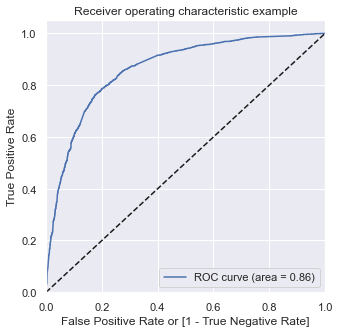

In [440]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

In [441]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Lead Number,Converted_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.176616,609431,0,1,1,0,0,0,0,0,0,0,0
1,0,0.053991,631817,0,1,0,0,0,0,0,0,0,0,0
2,0,0.016089,596164,0,1,0,0,0,0,0,0,0,0,0
3,0,0.181098,646570,0,1,1,0,0,0,0,0,0,0,0
4,0,0.028289,643974,0,1,0,0,0,0,0,0,0,0,0


In [442]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.424088  0.996350  0.071464
0.1   0.1  0.565708  0.974453  0.313843
0.2   0.2  0.665894  0.941200  0.496252
0.3   0.3  0.763915  0.869424  0.698901
0.4   0.4  0.794372  0.781427  0.802349
0.5   0.5  0.789889  0.629765  0.888556
0.6   0.6  0.765770  0.502433  0.928036
0.7   0.7  0.743352  0.401460  0.954023
0.8   0.8  0.703463  0.262774  0.975012
0.9   0.9  0.671923  0.159367  0.987756


<Figure size 1440x1080 with 0 Axes>

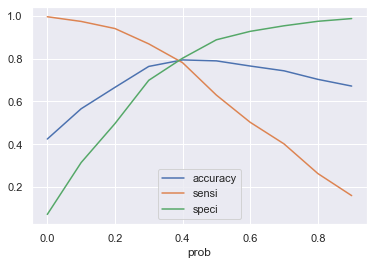

In [443]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
plt.figure(figsize=(20,15))
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
# plt.savefig('acc_s_s_curve',dpi=300,transparent=True)
plt.show()

- Taking value 0.37 as the Final Cutoff

In [444]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.37 else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Lead Number,Converted_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.176616,609431,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.053991,631817,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.016089,596164,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.181098,646570,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0.028289,643974,0,1,0,0,0,0,0,0,0,0,0,0


In [445]:
# Printing the Metrics Accuracy, Sensitivity, Specificity
accuracy,sensi,speci=metrices_(y_train_pred_final.Converted,y_train_pred_final.final_predicted)
print('Accuracy: {}'.format(accuracy))
print('Sensitivity: {}'.format(sensi))
print('Specificity: {}'.format(speci))

Accuracy: 0.7857142857142857
Sensitivity: 0.8102189781021898
Specificity: 0.7706146926536732


In [446]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Converted_pred )
confusion

array([[3556,  446],
       [ 913, 1553]], dtype=int64)

In [447]:
# Finding the Precision Score
precision_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.6851851851851852

In [448]:
# Finding the Recall Score
recall_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8102189781021898

In [449]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

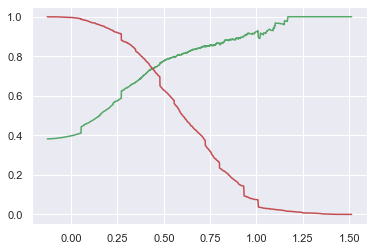

In [450]:
plt.plot(thresholds, p[:-1], "g-",label='Precision')
plt.plot(thresholds, r[:-1], "r-",label='Recall')
# plt.savefig('precision-recall_curve',dpi=300,transparent=True)
plt.show()

#### Making Prediction on test set

In [451]:
X_test[['Total Time Spent on Website','Page Views Per Visit','TotalVisits']]=scaler.transform(X_test[['Total Time Spent on Website','Page Views Per Visit','TotalVisits']])

In [452]:
#Adding constant
X_test_sm = sm.add_constant(X_test[col])
#Making prediction
y_test_pred = logm6.predict(X_test_sm)
y_test_pred[:10]

Lead Number
639211    0.755577
590711    0.855640
644174    0.474182
641392    0.342909
587955    0.784956
593130    0.155836
648319    0.053991
636722    0.995170
648231    0.771509
637858    0.256608
dtype: float64

In [453]:
# Converting y_pred to a dataframe which is an array
y_pred_test = pd.DataFrame(y_test_pred)
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df['Lead Number'] = y_test_df.index

In [454]:
# Removing index for both dataframes to append them side by side 
y_pred_test.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [455]:
# Appending y_test_df and y_pred_test
y_pred_final = pd.concat([y_test_df, y_pred_test],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})

In [456]:
y_pred_final.head()

,Converted,Lead Number,Converted_Prob
0,1,639211,0.755577
1,1,590711,0.855640
2,1,644174,0.474182
3,0,641392,0.342909
4,1,587955,0.784956


In [457]:
y_pred_final['final_test_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.37 else 0)

In [481]:
# Now let us calculate the lead score

y_train_pred_final['lead_score'] = y_train_pred_final.Converted_Prob.map(lambda x: round(x*100))
y_train_pred_final.head(20)

,Converted,Converted_Prob,Lead Number,Converted_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,lead_score
0,0,0.176616,609431,0,1,1,0,0,0,0,0,0,0,0,0,18
1,0,0.053991,631817,0,1,0,0,0,0,0,0,0,0,0,0,5
2,0,0.016089,596164,0,1,0,0,0,0,0,0,0,0,0,0,2
3,0,0.181098,646570,0,1,1,0,0,0,0,0,0,0,0,0,18
4,0,0.028289,643974,0,1,0,0,0,0,0,0,0,0,0,0,3
5,0,0.027199,614268,0,1,0,0,0,0,0,0,0,0,0,0,3
6,0,0.240730,633399,0,1,1,1,0,0,0,0,0,0,0,0,24
7,1,0.513379,615080,1,1,1,1,1,1,1,0,0,0,0,1,51
8,0,0.053991,627916,0,1,0,0,0,0,0,0,0,0,0,0,5
9,1,0.470405,622276,0,1,1,1,1,1,0,0,0,0,0,1,47


In [458]:
y_pred_final.head()

,Converted,Lead Number,Converted_Prob,final_test_predicted
0,1,639211,0.755577,1
1,1,590711,0.855640,1
2,1,644174,0.474182,1
3,0,641392,0.342909,0
4,1,587955,0.784956,1


In [459]:
accuracy,sensi,speci=metrices_(y_pred_final.Converted,y_pred_final.final_test_predicted)
print('Accuracy: {}'.format(accuracy))
print('Sensitivity: {}'.format(sensi))
print('Specificity: {}'.format(speci))

Accuracy: 0.7766955266955267
Sensitivity: 0.8018264840182648
Specificity: 0.7602862254025045


In [467]:
confusion2 = metrics.confusion_matrix(y_pred_final['Converted'], y_pred_final.final_test_predicted )
confusion2

array([[1275,  402],
       [ 217,  878]], dtype=int64)

In [468]:
# Finding the TP, TN, FP, FN
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negative

In [469]:
# Calculate Precision

TP/(TP+FP)

0.6859375

In [470]:
# Calculate Recall

TP/(TP+FN)

0.8018264840182648

- We can see that our model is doing well in test set also
- Sensitivity means how our model is telling that actually converted and model prdecited them as as converted.
- We can see that our model is giving about .80 sensitivity.
- it means that 80 percent time our model is able to predict (actually)converted as (predicted)converted.

#### Assigning Lead Score in the data frame with respect to Lead Number

In [460]:
# making new df with lead score
lead_scorer_df=pd.DataFrame()
df1=y_train_pred_final[['Lead Number','Converted_Prob']]
df2=y_pred_final[['Lead Number','Converted_Prob']]

In [461]:
lead_scorer_df=df1.append(df2,ignore_index=True)

In [462]:
# Assigning the value to the Lead Score by Multiplying 100
lead_scorer_df['Lead Score']=lead_scorer_df['Converted_Prob'].apply(lambda x: round((x*100),2))


In [463]:
# dropping Converted_Prob
lead_scorer_df.drop('Converted_Prob',1,inplace=True)
lead_scorer_df.head()

,Lead Number,Lead Score
0,609431,17.66
1,631817,5.40
2,596164,1.61
3,646570,18.11
4,643974,2.83


In [472]:
# # checking if 80% cases are correctly predicted based on the converted column.

# # get the total of final predicted conversion or non conversion counts from the actual converted rates

checking_test_df = y_pred_final.loc[y_pred_final['Converted']==1,['Converted','final_test_predicted']]
checking_test_df['final_test_predicted'].value_counts()

1    878
0    217
Name: final_test_predicted, dtype: int64

In [473]:
878/float(878+217)

0.8018264840182648

In [474]:
# Let's check the accuracy.

metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_test_predicted)

0.7766955266955267

In [475]:
confusion4 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_test_predicted )
confusion4

array([[1275,  402],
       [ 217,  878]], dtype=int64)

In [476]:
# Finding the TP, TN, FP, FN
TP = confusion4[1,1] # true positive 
TN = confusion4[0,0] # true negatives
FP = confusion4[0,1] # false positives
FN = confusion4[1,0] # false negative

In [477]:
accuracy,sensi,speci=metrices_(y_pred_final.Converted, y_pred_final.final_test_predicted)

print('Accuracy: {}'.format(accuracy))
print('Sensitivity: {}'.format(sensi))
print('Specificity: {}'.format(speci))

Accuracy: 0.7766955266955267
Sensitivity: 0.8018264840182648
Specificity: 0.7602862254025045


In [478]:
# Calculate false postive rate -
print('False Positive Rate:',(FP/ float(TN+FP)))
# positive predictive value 
print ('Positive Predicitve Rate:', (TP / float(TP+FP)))
# Negative predictive value
print ('Negative Predictive Rate:', (TN / float(TN+ FN)))

False Positive Rate: 0.23971377459749552
Positive Predicitve Rate: 0.6859375
Negative Predictive Rate: 0.8545576407506702


In [479]:
# precision
print ('Precision:', (TP/float(TP+FP)))
# recall
print ('Recall:', (TP/float(TP+FN)))

Precision: 0.6859375
Recall: 0.8018264840182648


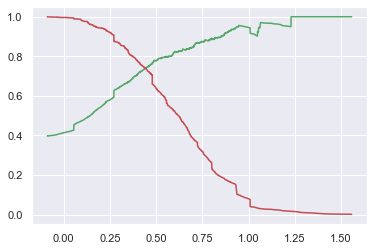

In [480]:

p, r, thresholds = precision_recall_curve(y_pred_final.Converted, y_pred_final.Converted_Prob)

plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Conclusion :-
- from the above analysis we can observe that the leads generated in the initial stage were high, but later only few of them become as a prospective customers.
- out of all the variables observed, 'TotalVisits' , 'Total Time Spent on Website' , 'Page Views Per Visit' contribute most towards the probability of a lead getting converted.
- Focusing on converted leads. it is vital to extract the right information needed for the improving the conversion rate.
- Frequent follow-ups with the prospective customers and the leads will make the conversion rate high.